In [146]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf
import matplotlib.pyplot as plt

#### Semivarianza y Semidesvío

In [46]:
## descargo data para tener
gallega = yf.download(tickers = "GGAL.BA", period = "ytd")
gallega = gallega["Adj Close"]
retornos = gallega.pct_change() * 100
retornos = retornos.dropna()

[*********************100%***********************]  1 of 1 completed


In [63]:
def semivarianza(retornos):
    ## centramos retornos
    centrados = retornos - retornos.mean()
    
    ## a cada valor le tomamos el min(x,0)
    ## o lo que es lo mismo: clippeamos por arriba en 0 
    ## (si pasa 0, lo dejamos en 0)
    centrados = centrados.clip(upper=0)
    ## elevamos al cuadrado
    centrados_sq = centrados.pow(2)
    ## sumamos y dividimos por la cantidad de filas
    centrados_sq = centrados_sq.sum()/centrados_sq.shape[0]  
    return centrados_sq

def semidesvio(retornos):
    return np.sqrt(semivarianza(retornos))

In [64]:
semivarianza(retornos)

2.6773958072154964

In [65]:
semidesvio(retornos)

1.6362749790959636

#### Cuantil como métrica de riesgo

El cuantil es el valor que te deja por detrás un p% de la distribución. Por ejemplo, el cuantil 5 te deja el 5% de la distribución por detrás. O dicho de otra manera: dado un cuantil a, p(X <  x) = a

In [143]:
r = norm.rvs(size=10000, loc=0, scale=4)

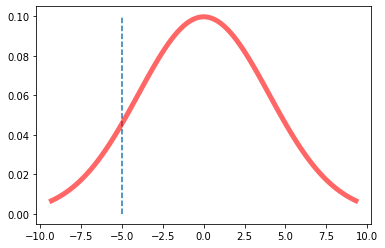

In [163]:
x  = np.linspace(norm.ppf(0.01,loc=0, scale=4), norm.ppf(0.99, loc=0, scale=4), 100)
plt.plot(x, norm.pdf(x, loc=0, scale=4), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.vlines(x=-5, ymin=0, ymax=0.1, linestyle = "--")

In [166]:
## si el cuantil 0.1 está en -5 ¿cual es el area que queda por detras de -5?
## para eso usamos cdf: Cumulative distribution function.

norm.cdf( -5,loc= 0., scale=4) 

## loc es media, scale es desvio. Acá los pongo yo a mano para que me reproduzca 
## el gráfico del profe. Pero en general es algo que no sabemos, que tenemos que estimar. 

0.10564977366685535

Cdf te da el area dado el punto de corte. Por ejemplo, en el caso anterior  cdf(-5, loc=0, scale=4) te dice: para una normal de media 0, desvio 4, ¿cual es la proba de sacar un valor menor a -5?

In [180]:
## pagina 17:
# si tenemos un retorno que se distribuye normalmente con una media de 10% y desviación
# estándar del 25%, entonces la probabilidad de obtener un retorno menor del 5% es del 42%, porque:

norm.cdf(.05, loc=.10, scale=.25) ## 42%

0.42074029056089696

pagina 18:
Ejemplo: probabilidad de obtener un desempeño menor al
benchmark: Consideremos un fondo cuyos rendimientos futuros se
distribuyen normalmente, con un rendimiento esperado durante el
próximo año del 1% y una desviación estándar sobre este
rendimiento activo (tracking error o error de seguimiento) del 3%.
¿Cuál es la probabilidad de tener un rendimiento inferior al
benchmark, por ejemplo de -2% o más durante el próximo año?

In [187]:
norm.cdf(-0.02, loc=.01, scale=.03) 

0.15865525393145707

¿Cuál es el VaR al 10% en un horizonte de 1 año de $ 2
millones invertidos en un fondo cuyos retornos anuales (por encima a
la tasa libre de riesgo) que se supone que se distribuyen
normalmente, tienen una media del 5% y una volatilidad del 12%?

In [235]:
## hasta acá habíamos usado cdf. 
## podemos hacer la inversa. Percent point function (inverse of cdf — percentiles).
## o ppf. Hasta acá, con cdf, calculabamos el área dado un punto de corte.
## acá lo que hacemos es responder ¿cual es el punto de corte dado el área?
## Por ejemplo, ¿cual es el valor que nos deja un var al 10%?

## para una normal con media .05 y un desvio de .12, obtenemos:
norm.ppf(0.1, loc=.05, scale=.12) 

-0.10378618786535203

Por lo tanto el VaR al 10% en un horizonte de un año es 0.1038 ∗ 2 millones = 207,572. Es decir, estamos
90% seguros de que no perderemos un monto mayor que este en el próximo año.

In [236]:
## para 2 millones entonces:
plata = 2000000
norm.ppf(0.1, loc=.05, scale=.12)  * plata

-207572.37573070405

En las diapos el profe usa mucho multiplicar por sigma y restarle mu. Por que nosotros acá no? Porque eso es para pasar de Z a la escala original. Acá con pasarle mu a loc u sigma a scale, scipy te lo hace solo. 

Aproximamos retornos semanales con los diarios

In [237]:
## me copio el ejemplo de la diapo (p.35)
ej = [1211.92, 1202.08, 1188.05, 1183.74, 1187.89, 1186.19]
ej = pd.Series(ej)

In [241]:
## calculo retornos log
log_r = np.log(ej/ej.shift(1))

In [242]:
log_r

0         NaN
1   -0.008152
2   -0.011740
3   -0.003634
4    0.003500
5   -0.001432
dtype: float64

In [250]:
## la suma de los retornos diarios me da parecido al retorno a 5 días:

## divido el ultimo (-1) por el primero (0)
## y le calculo el logaritmo
log_r_total = np.log(ej.iloc[-1]/ej.iloc[0])

## sumo todos los retornos logaritmicos
log_r_aprox = log_r.sum()

## son parecidos?
np.isclose(log_r_total, log_r_aprox)

True

In [257]:
## como se calcularía el var al 10% usando a 5 días en vez de diario?

## supongamos un retorno diario con media del 1%
## y desvio del 2%

## el var al 10% diario sería:
var_10_diario = norm.ppf(0.1, loc=.01, scale=.02) 
print(var_10_diario)

## y a 5 dias: alcanza con multiplicar el var por la raiz cuadrada de la cantidad de días
var_5_dias = norm.ppf(0.1, loc=.01, scale=.02) * np.sqrt(5)
print(var_5_dias)

-0.01563103131089201
-0.034952048569582186


Tenemos una cartera tiene rendimientos diarios, descontados al día
de hoy, que se distribuyen Niid con una expectativa del 0% y
desviación estándar del 1,5%.
Estimemos el VaR de 1% a 1 día. Luego el VaR a 10 días al 1% bajo el
supuesto de que los rendimientos en exceso diarios (a) son
independientes y (b) siguen un proceso autorregresivo de primer
orden con autocorrelación de 0.25.
¿La autocorrelación positiva aumenta o disminuye el VaR?

In [268]:
0.25*10 + 10

12.5

In [260]:
var_1_1 = norm.ppf(.01, loc=0, scale=0.015)
var_10_1 = var_1_1 * np.sqrt(10)

print(f"El var al 1% de 1 día es de {round(var_1_1 * 100,2)}%. A 10 días me queda en {round(var_10_1 * 100,2)}%
      ")

El var al 1% de 1 día es de -3.49%. A 10 días me queda en -11.03%
